# Periodic Gene Expression Analysis

**Cell Cycle Gene Expression Clustering**

This notebook analyzes periodic gene expression patterns from cell cycle experiments. It includes expression profile visualization, peak detection using watershed-style algorithms, and identification of genes with similar temporal patterns.


## Imports / setup


In [68]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Loading and Inspecting the Data

This analysis uses the perturbed, cell-cycle–synchronized expression dataset from Dominguez *et al.* (2016), stored in the file `periodic_gene_expression.tsv`.

Each **row** in the file corresponds to a gene and is identified by its numerical ID. Each **column** represents a time point in the cell cycle experiment, with expression values measured at regular intervals.


In [69]:
# Path to the tab-separated periodic gene expression file
data_file_path = "../data/periodic_gene_expression.tsv"

# Load the expression matrix:
# - rows    = genes (index = gene IDs)
# - columns = cell-cycle time points
expr_df = pd.read_csv(
    data_file_path,
    sep="\t",
    header=None,
    index_col=0
)

# Inspect basic structure: (number of genes, number of time points)
expr_df.shape, expr_df.head()


((8813, 56),
          1         2         3         4         5         6         7   \
 0                                                                         
 0  0.132542  0.227641  0.148282  0.055420  0.173426  0.212824  0.295932   
 1  0.215197  0.378163  0.400179  0.173974  0.263814  0.556717  0.495361   
 2  0.122402  0.247476  0.231400  0.117036  0.180332  0.309252  0.367298   
 3  0.135091  0.249432  0.198000  0.088625  0.267934  0.382187  0.414468   
 4  0.163189  0.210381  0.223441  0.053721  0.155073  0.206997  0.281916   
 
          8         9         10  ...        47        48        49        50  \
 0                                ...                                           
 0  0.106484  0.053265  0.095814  ...  0.544871  0.620946  0.155174  0.451141   
 1  0.350477  0.029480  0.232456  ...  0.371614  0.449575  0.000000  0.217877   
 2  0.198849  0.018078  0.082632  ...  0.610129  0.539209  0.251884  0.478210   
 3  0.172162  0.151698  0.263706  ...  0.192407 

## Visualizing Periodic Expression Patterns

As a first analysis step, we plot the expression profiles of four selected genes together in one figure:

- gene **766**
- gene **932**
- gene **3297**
- gene **4685**

This allows us to visually compare their periodic patterns across the cell cycle.


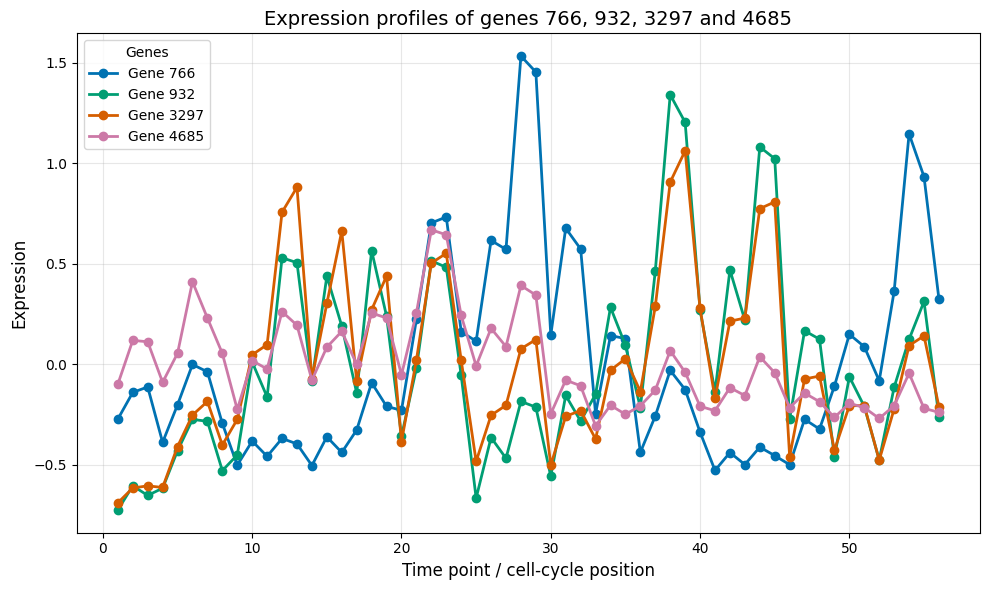

In [70]:
# IDs of the genes to be visualized (they are row indices in expr_df)
gene_ids = [766, 932, 3297, 4685]

# Extract the expression profiles of these genes and transpose:
# After transpose:
#   - rows    = time points
#   - columns = selected genes
expr_sub = expr_df.loc[gene_ids].T

plt.style.use("seaborn-v0_8-colorblind")
plt.figure(figsize=(10, 6))

# Plot each gene as a separate line
for gene_id in gene_ids:
    plt.plot(
        expr_sub.index,        # x-axis: time points (column indices)
        expr_sub[gene_id],     # y-axis: expression values
        marker="o",
        linewidth=2,
        label=f"Gene {gene_id}"
    )

plt.xlabel("Time point / cell-cycle position", fontsize=12)
plt.ylabel("Expression", fontsize=12)
plt.title("Expression profiles of genes 766, 932, 3297 and 4685", fontsize=14)

plt.grid(alpha=0.3)
plt.legend(title="Genes", fontsize=10)
plt.tight_layout()
plt.show()


## Watershed-Style Peak Detection

To automatically identify expression peaks along the cell cycle, we implement a simple **1D watershed-inspired** algorithm.

We treat the expression values of a single gene as a 1D landscape:

- High expression values correspond to "peaks" or "hills"
- Low expression values correspond to "valleys"

The algorithm identifies local maxima (peaks) by comparing each point to its neighbors within a specified adjacency threshold.
